Import Dataset


In [2]:
import os
import json
import random
from collections import defaultdict, Counter
import shutil
import sys, math, re, time
import numpy as np
import cv2
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageEnhance, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img

In [ ]:
# # โหลด json ที่อัปโหลดไว้
# with open("C:/Users/User/OneDrive/Desktop/Isme/Image Classification of Tomato/kaggle.json", "r") as f:
#     kaggle_data = json.load(f)

# # ตั้งค่าตัวแปร environment
# os.environ['KAGGLE_USERNAME'] = kaggle_data['username']
# os.environ['KAGGLE_KEY'] = kaggle_data['key']

# # ดาวน์โหลด dataset
# !kaggle datasets download -d emmarex/plantdisease

# # แตกไฟล์ .zip ด้วย zipfile (แทน !unzip)
# with zipfile.ZipFile("plantdisease.zip", 'r') as zip_ref:
#     zip_ref.extractall("plant_disease_data")


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown




  0%|          | 0.00/658M [00:00<?, ?B/s]
 15%|█▌        | 99.0M/658M [00:00<00:00, 946MB/s]
 29%|██▉       | 190M/658M [00:00<00:00, 663MB/s] 
 39%|███▉      | 258M/658M [00:00<00:00, 567MB/s]
 48%|████▊     | 315M/658M [00:00<00:00, 538MB/s]
 56%|█████▌    | 368M/658M [00:00<00:00, 496MB/s]
 63%|██████▎   | 416M/658M [00:00<00:00, 494MB/s]
 72%|███████▏  | 472M/658M [00:00<00:00, 515MB/s]
 81%|████████  | 531M/658M [00:01<00:00, 540MB/s]
 89%|████████▉ | 584M/658M [00:01<00:00, 534MB/s]
 97%|█████████▋| 636M/658M [00:01<00:00, 536MB/s]
100%|██████████| 658M/658M [00:01<00:00, 548MB/s]


In [29]:
base_path = "C:/Users/User/OneDrive/Desktop/Isme/Image Classification of Tomato/plant_disease_data/PlantVillage"
# folders = os.listdir(base_path)
# folders = sorted([f for f in folders if os.path.isdir(os.path.join(base_path, f))])
# folders

In [30]:
# --- Selected Class 10 class ---
selected_classes = [
    'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight',
    'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy']

In [5]:
#ตัวแปรสำหรับเก็บข้อมูลภาพและคลาส
image_paths = []
image_labels = []

#ลูปเพื่อเก็บข้อมูลภาพ
for cls in selected_classes:
    folder_path = os.path.join(base_path, cls)
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder_path, file))
            image_labels.append(cls)

ตรวจสอบขนาดรูปภาพ

In [11]:
sizes = set()

for path in image_paths:
    try:
        with Image.open(path) as img:
            sizes.add(img.size)  # img.size คืนค่า (width, height)
    except Exception as e:
        print(f" ไม่สามารถเปิดภาพ: {path}\n  สาเหตุ: {e}")

# แสดงผล
if len(sizes) == 1:
    print(f"ขนาดรูปภาพทั้งหมดเท่ากัน: {sizes.pop()}")
else:
    print(f"พบขนาดรูปภาพหลายขนาด: {sizes}")

# นับจำนวนภาพแต่ละคลาส
label_counts = Counter(image_labels)

# แสดงผลจำนวนภาพต่อคลาส
print("\nจำนวนภาพในแต่ละคลาส:")
for label, count in label_counts.items():
    print(f" - {label}: {count} รูป")


ขนาดรูปภาพทั้งหมดเท่ากัน: (256, 256)

จำนวนภาพในแต่ละคลาส:
 - Tomato_Bacterial_spot: 2127 รูป
 - Tomato_Early_blight: 1000 รูป
 - Tomato_Late_blight: 1909 รูป
 - Tomato_Leaf_Mold: 952 รูป
 - Tomato_Septoria_leaf_spot: 1771 รูป
 - Tomato_Spider_mites_Two_spotted_spider_mite: 1676 รูป
 - Tomato__Target_Spot: 1404 รูป
 - Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 รูป
 - Tomato__Tomato_mosaic_virus: 373 รูป
 - Tomato_healthy: 1591 รูป


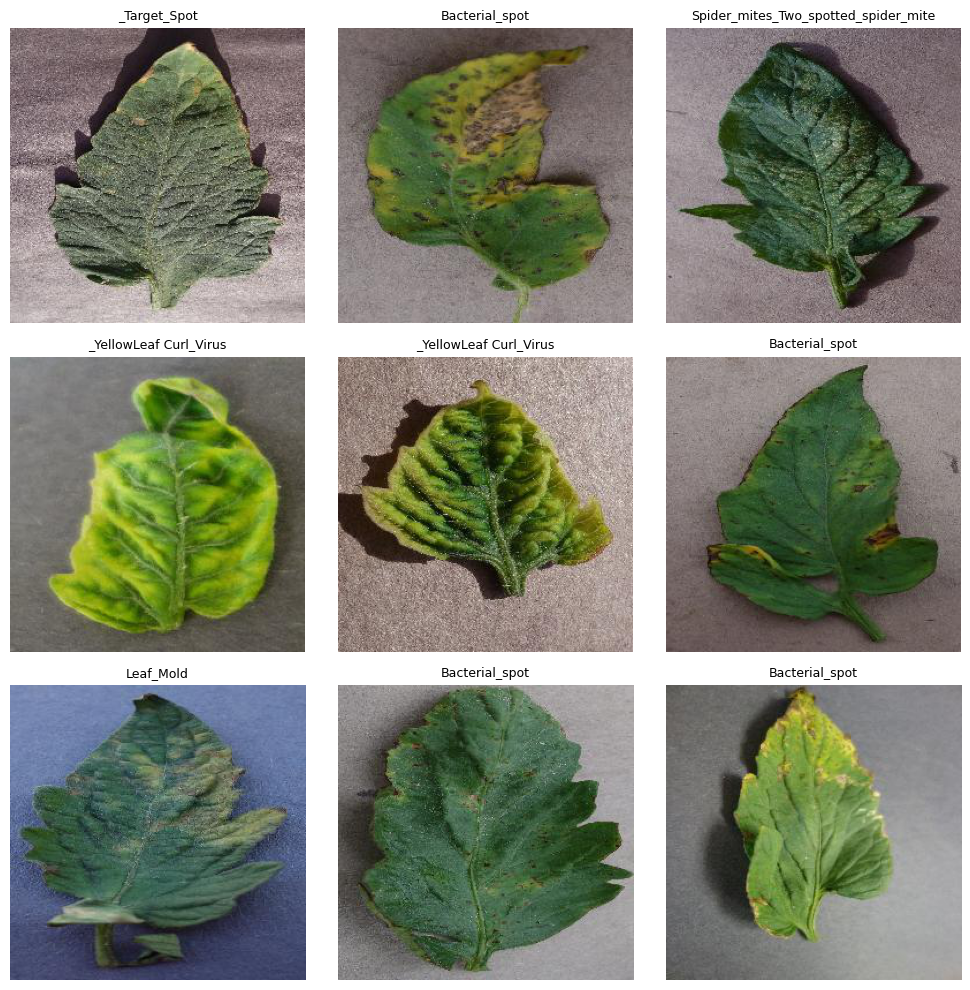

In [12]:
# สุ่ม 9 รูปจาก image_paths
num_images = 9
indices = random.sample(range(len(image_paths)), num_images)

plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    img_path = image_paths[idx]
    label = image_labels[idx].replace('Tomato_', '').replace('__', ' ')

    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


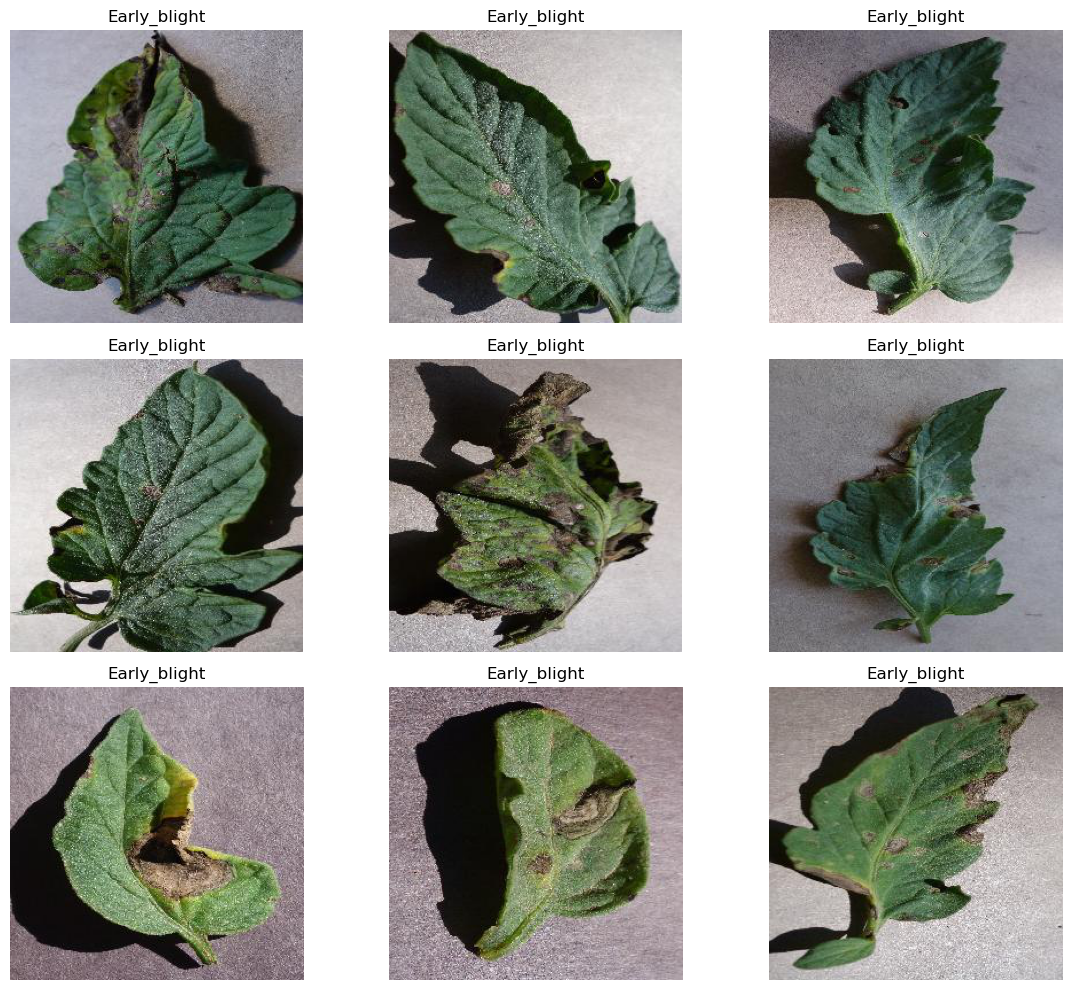

In [13]:
# เลือกคลาสที่ต้องการดู
selected_class_name = 'Tomato_Early_blight'

#Name Class
#'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight',
# 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
# 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot',
# 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus',
# 'Tomato_healthy'

# ดึง path ของภาพที่ตรงกับคลาสนั้น
class_image_paths = []
for p, l in zip(image_paths, image_labels):
    if l == selected_class_name:
        class_image_paths.append(p)


# สุ่มภาพมาแสดง 9 รูป (ถ้ามีน้อยกว่า 9 จะแสดงเท่าที่มี)
num_images = min(9, len(class_image_paths))
selected_images = random.sample(class_image_paths, num_images)

# แสดงภาพ
plt.figure(figsize=(12, 10))
for i, img_path in enumerate(selected_images):
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(selected_class_name.replace('Tomato_', ''))
    plt.axis('off')

plt.tight_layout()
plt.show()

#data preparation

1.สุ่มเลือกภาพจากแต่ละคลาสได้ไม่เกิน 1000 รูป โดยกำหนด seed เพื่อให้ได้ผลลัพธ์ซ้ำได้ และรองรับกรณีที่บางคลาสมีรูปภาพไม่ถึง 1000 รูป

In [ ]:
# # กำหนดค่าเริ่มต้น สุ่มไม่เกิน 1000 รูปต่อคลาส
# target_count = 1000
# random.seed(42)

# # สร้าง dictionary สำหรับจัดกลุ่ม path ตามคลาส
# class_to_paths = defaultdict(list)

# # จัดกลุ่ม path ตาม label เดิม
# for path, label in zip(image_paths, image_labels):
#     class_to_paths[label].append(path)

# # ตัวแปรสำหรับเก็บ path และ label ที่สุ่มได้ใหม่
# image_paths_1000 = []
# image_labels_1000 = []

# # สุ่มเลือกไม่เกิน 1000 รูปต่อคลาส
# for cls, paths in class_to_paths.items():
#     selected = random.sample(paths, min(target_count, len(paths)))
    
#     # แปลงเป็น Path object เพื่อความเสถียรของ path
#     selected_paths = [Path(p) for p in selected]
    
#     image_paths_1000.extend(selected_paths)
#     image_labels_1000.extend([cls] * len(selected_paths))


In [ ]:
# image_paths_1000[:5]

[WindowsPath('C:/Users/User/OneDrive/Desktop/Isme/Image Classification of Tomato/plant_disease_data/PlantVillage/Tomato_Bacterial_spot/3a28881d-eede-4274-b158-c54ebd1c7164___GCREC_Bact.Sp 3136.JPG'),
 WindowsPath('C:/Users/User/OneDrive/Desktop/Isme/Image Classification of Tomato/plant_disease_data/PlantVillage/Tomato_Bacterial_spot/0d227915-443b-402c-8a25-cc43434c4bb0___GCREC_Bact.Sp 5913.JPG'),
 WindowsPath('C:/Users/User/OneDrive/Desktop/Isme/Image Classification of Tomato/plant_disease_data/PlantVillage/Tomato_Bacterial_spot/8c9f86a5-70df-4ab0-bb33-1bd4ea9cb91e___UF.GRC_BS_Lab Leaf 0846.JPG'),
 WindowsPath('C:/Users/User/OneDrive/Desktop/Isme/Image Classification of Tomato/plant_disease_data/PlantVillage/Tomato_Bacterial_spot/7f0a444d-f5ca-4378-a06d-fa94469f2ae1___GCREC_Bact.Sp 3686.JPG'),
 WindowsPath('C:/Users/User/OneDrive/Desktop/Isme/Image Classification of Tomato/plant_disease_data/PlantVillage/Tomato_Bacterial_spot/7334e742-de72-4561-9b0d-cdd8bc3313e7___GCREC_Bact.Sp 3066.JP

In [ ]:
 selected_path = "selected_tomato"
 target_count = 1000
 #--- COPY ---
def copy_images():
    for cls in selected_classes:
        src, dst = os.path.join(base_path, cls), os.path.join(selected_path, cls)
        os.makedirs(dst, exist_ok=True)
        if not os.path.exists(src):
            print(f" Not found: {src}")
            continue
        images = [f for f in os.listdir(src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        selected = random.sample(images, target_count) if len(images) > target_count else images
        for img in selected:
            shutil.copy(os.path.join(src, img), os.path.join(dst, img))
        print(f"{cls}: copied {len(selected)} images.")

#เรียกใช้งาน
copy_images()

Tomato_Bacterial_spot: copied 1000 images.
Tomato_Early_blight: copied 1000 images.
Tomato_Late_blight: copied 1000 images.
Tomato_Leaf_Mold: copied 952 images.
Tomato_Septoria_leaf_spot: copied 1000 images.
Tomato_Spider_mites_Two_spotted_spider_mite: copied 1000 images.
Tomato__Target_Spot: copied 1000 images.
Tomato__Tomato_YellowLeaf__Curl_Virus: copied 1000 images.
Tomato__Tomato_mosaic_virus: copied 373 images.
Tomato_healthy: copied 1000 images.


2.ทำ Data Augmentation สำหรับคลาสที่มี < 1000 รูป

In [ ]:
# def augment_and_save_images(image_paths, image_labels, save_root="Tomato_Augmentation", target_per_class=1000, augment_per_image=5):
#     # สร้างโฟลเดอร์หลัก
#     os.makedirs(save_root, exist_ok=True)

#     # เตรียม Data Augmentation
#     datagen = ImageDataGenerator(
#         rotation_range=25, # หมุนภาพได้สูงสุด 25 องศา
#         width_shift_range=0.1, # เลื่อนภาพแนวนอน/แนวตั้งได้ 10%
#         height_shift_range=0.1,
#         shear_range=0.1, # บิดภาพ (shear) ได้ 10%
#         zoom_range=0.2, # ซูมเข้าออกได้ 20%
#         horizontal_flip=True, # กลับภาพในแนวนอน
#         fill_mode='nearest' # เติมขอบภาพด้วยค่าที่ใกล้เคียง (nearest)
#     )

#     # สร้าง dict เก็บภาพต่อคลาส
#     class_to_images = defaultdict(list)
#     for path, label in zip(image_paths, image_labels):
#         class_to_images[label].append(path)

#     for label, paths in class_to_images.items():
#         current_count = len(paths)
#         need_aug = target_per_class - current_count

#         if need_aug <= 0:
#             print(f"✅ ข้ามคลาส {label} (มี {current_count} รูป)")
#             continue

#         print(f"⚙️ ทำ Augmentation สำหรับคลาส '{label}' (มี {current_count} ต้องเพิ่ม {need_aug})")
#         class_dir = os.path.join(save_root, label)
#         os.makedirs(class_dir, exist_ok=True)

#         generated = 0
#         while generated < need_aug:
#             img_path = random.choice(paths)
#             try:
#                 img = load_img(img_path)
#                 img_array = img_to_array(img)
#                 img_array = np.expand_dims(img_array, axis=0)

#                 for batch in datagen.flow(img_array, batch_size=1):
#                     out_path = os.path.join(class_dir, f"{label}_aug_{generated}.jpg")
#                     img_aug = Image.fromarray(batch[0].astype(np.uint8))
#                     img_aug.save(out_path)

#                     generated += 1
#                     if generated >= need_aug:
#                         break

#             except Exception as e:
#                 print(f"❌ ไม่สามารถประมวลผล {img_path}: {e}")

#     print("✅ เสร็จสิ้นการทำ Augmentation สำหรับคลาสที่ต้องการเพิ่มรูป")

# # เรียกใช้ฟังก์ชัน
# augment_and_save_images(image_paths_1000, image_labels_1000)


✅ ข้ามคลาส Tomato_Bacterial_spot (มี 1000 รูป)
✅ ข้ามคลาส Tomato_Early_blight (มี 1000 รูป)
✅ ข้ามคลาส Tomato_Late_blight (มี 1000 รูป)
⚙️ ทำ Augmentation สำหรับคลาส 'Tomato_Leaf_Mold' (มี 952 ต้องเพิ่ม 48)
✅ ข้ามคลาส Tomato_Septoria_leaf_spot (มี 1000 รูป)
✅ ข้ามคลาส Tomato_Spider_mites_Two_spotted_spider_mite (มี 1000 รูป)
✅ ข้ามคลาส Tomato__Target_Spot (มี 1000 รูป)
✅ ข้ามคลาส Tomato__Tomato_YellowLeaf__Curl_Virus (มี 1000 รูป)
⚙️ ทำ Augmentation สำหรับคลาส 'Tomato__Tomato_mosaic_virus' (มี 373 ต้องเพิ่ม 627)
✅ ข้ามคลาส Tomato_healthy (มี 1000 รูป)
✅ เสร็จสิ้นการทำ Augmentation สำหรับคลาสที่ต้องการเพิ่มรูป


In [32]:
# --- AUGMENT ---
def augment_images():
    datagen = ImageDataGenerator(
        rotation_range=25, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        shear_range=0.1, 
        zoom_range=0.2,
         horizontal_flip=True, 
         fill_mode='nearest'
    )
    for cls in os.listdir(selected_path):
        cls_path = os.path.join(selected_path, cls)
        if not os.path.isdir(cls_path): continue
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        count = len(images)
        if count >= target_count:
            print(f"✓ {cls}: already {count}")
            continue
        if count == 0:
            print(f"{cls}: no images found")
            continue

        i = 0
        while count + i < target_count:
            img = load_img(os.path.join(cls_path, random.choice(images)))
            x = img_to_array(img).reshape((1,) + img.size[::-1] + (3,))
            for batch in datagen.flow(x, batch_size=1):
                save_img(os.path.join(cls_path, f"aug_{i}.jpg"), array_to_img(batch[0]))
                i += 1
                if count + i >= target_count: break
        print(f"{cls}: augmented {i} images to reach {count + i}")

augment_images()

✓ Tomato_Bacterial_spot: already 1000
✓ Tomato_Early_blight: already 1000
✓ Tomato_healthy: already 1000
✓ Tomato_Late_blight: already 1000
Tomato_Leaf_Mold: augmented 48 images to reach 1000
✓ Tomato_Septoria_leaf_spot: already 1000
✓ Tomato_Spider_mites_Two_spotted_spider_mite: already 1000
✓ Tomato__Target_Spot: already 1000
Tomato__Tomato_mosaic_virus: augmented 627 images to reach 1000
✓ Tomato__Tomato_YellowLeaf__Curl_Virus: already 1000


2.Normalization: หารค่าพิกเซลด้วย 255 เพื่อให้อยู่ในช่วง [0, 1]

In [ ]:

# def normalize_images(image_paths_1000):
#     normalized_images = []
#     normalized_labels = []  # เก็บ label คู่กันไว้

#     for img_path, label in zip(image_paths_1000, image_labels_1000):
#         try:
#             img = load_img(img_path)
#             img_array = img_to_array(img)

#             # ทำ Normalization: หารค่าพิกเซลด้วย 255.0
#             normalized_img = img_array / 255.0
#             normalized_images.append(normalized_img)
#             normalized_labels.append(label)

#         except Exception as e:
#             print(f"โหลด {img_path} ไม่สำเร็จ: {e}")

#     return normalized_images, normalized_labels

# # เรียกใช้งาน
# normalized_images, normalized_labels = normalize_images(image_paths_1000)



In [ ]:
# print(normalized_images[:1])  # จะได้เพียง 1 รูปที่ถูก Normalize

In [ ]:
# # สุ่มเลือก 9 รูป
# indices = random.sample(range(len(normalized_images)), 9)
# selected_images = [normalized_images[i] for i in indices]
# selected_labels = [normalized_labels[i] for i in indices]

# # แสดงผลรูปในตาราง 3x3
# plt.figure(figsize=(9, 9))
# for i in range(9):
#     plt.subplot(3, 3, i+1)
#     plt.imshow(selected_images[i])
#     plt.title(selected_labels[i])
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

3.ทำ Data Augmentation สำหรับคลาสที่มี < 1000 รูป

In [ ]:
# # ฟังก์ชันสำหรับทำ Data Augmentation
# def augment_from_normalized(normalized_images, normalized_labels, target_count_per_class=1000):
#     datagen = ImageDataGenerator(
#         rotation_range=25, # หมุนภาพได้สูงสุด 25 องศา
#         width_shift_range=0.1, # เลื่อนภาพแนวนอน/แนวตั้งได้ 10%
#         height_shift_range=0.1,
#         shear_range=0.1, # บิดภาพ (shear) ได้ 10%
#         zoom_range=0.2, # ซูมเข้าออกได้ 20%
#         horizontal_flip=True, # กลับภาพในแนวนอน
#         fill_mode='nearest' # เติมขอบภาพด้วยค่าที่ใกล้เคียง (nearest)
#     )

#     class_to_images = defaultdict(list)
#     for img, label in zip(normalized_images, normalized_labels):
#         class_to_images[label].append(img)

#     augmented_images = []  # ตัวแปรสำหรับเก็บรูปที่ผ่านการ Augment
#     augmented_labels = []  # ตัวแปรสำหรับเก็บ label ของรูปที่ถูก Augment

#     for cls, imgs in class_to_images.items():
#         current_count = len(imgs)
#         i = 0

#         while current_count + i < target_count_per_class:
#             img = random.choice(imgs)
#             img = np.expand_dims(img, axis=0)  # เพิ่มมิติให้กับรูปภาพ เพื่อให้เหมาะสมกับการใช้ ImageDataGenerator
#             for batch in datagen.flow(img, batch_size=1):
#                 augmented_images.append(batch[0])  # เพิ่มรูปที่ถูก Augment
#                 augmented_labels.append(cls)  # เพิ่ม label ของรูปที่ถูก Augment
#                 i += 1
#                 if current_count + i >= target_count_per_class:
#                     break

#         print(f"{cls}: augmented {i} images")

#     return augmented_images, augmented_labels  # คืนค่าภาพที่ทำ Data Augmentation และ labels

# # เรียกใช้งานฟังก์ชัน
# augmented_images, augmented_labels = augment_from_normalized(normalized_images, normalized_labels, target_count_per_class=1000)

# # ผลลัพธ์: augmented_images จะมีรูปที่ถูกทำ Data Augmentation และ augmented_labels จะมี labels ที่เกี่ยวข้อง


Tomato_Bacterial_spot: augmented 0 images
Tomato_Early_blight: augmented 0 images
Tomato_Late_blight: augmented 0 images
Tomato_Leaf_Mold: augmented 48 images
Tomato_Septoria_leaf_spot: augmented 0 images
Tomato_Spider_mites_Two_spotted_spider_mite: augmented 0 images
Tomato__Target_Spot: augmented 0 images
Tomato__Tomato_YellowLeaf__Curl_Virus: augmented 0 images
Tomato__Tomato_mosaic_virus: augmented 627 images
Tomato_healthy: augmented 0 images


Split

In [34]:
final_dataset_path = "tomato_dataset_split"
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}
os.makedirs(selected_path, exist_ok=True)

In [35]:
# --- SPLIT ---
def split_dataset():
    for split in split_ratio:
        for cls in selected_classes:
            os.makedirs(os.path.join(final_dataset_path, split, cls), exist_ok=True)

    for cls in selected_classes:
        src_cls_path = os.path.join(selected_path, cls)
        images = [f for f in os.listdir(src_cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)
        total = len(images)
        train_end = int(total * split_ratio['train'])
        val_end = train_end + int(total * split_ratio['val'])

        split_map = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, split_imgs in split_map.items():
            for img in split_imgs:
                src = os.path.join(src_cls_path, img)
                dst = os.path.join(final_dataset_path, split, cls, img)
                shutil.copy(src, dst)
        print(f"{cls}: split into {[(k, len(v)) for k, v in split_map.items()]}")

#เรียกใช้งาน
split_dataset()


Tomato_Bacterial_spot: split into [('train', 700), ('val', 150), ('test', 150)]
Tomato_Early_blight: split into [('train', 700), ('val', 150), ('test', 150)]
Tomato_Late_blight: split into [('train', 700), ('val', 150), ('test', 150)]
Tomato_Leaf_Mold: split into [('train', 700), ('val', 150), ('test', 150)]
Tomato_Septoria_leaf_spot: split into [('train', 700), ('val', 150), ('test', 150)]
Tomato_Spider_mites_Two_spotted_spider_mite: split into [('train', 700), ('val', 150), ('test', 150)]
Tomato__Target_Spot: split into [('train', 700), ('val', 150), ('test', 150)]
Tomato__Tomato_YellowLeaf__Curl_Virus: split into [('train', 700), ('val', 150), ('test', 150)]
Tomato__Tomato_mosaic_virus: split into [('train', 700), ('val', 150), ('test', 150)]
Tomato_healthy: split into [('train', 700), ('val', 150), ('test', 150)]


In [3]:
# --- CONFIG ---
train_dir = "tomato_dataset_split/train"
val_dir = "tomato_dataset_split/val"
test_dir = "tomato_dataset_split/test"

In [4]:
# สร้าง ImageDataGenerator สำหรับการโหลดข้อมูล
train_datagen = ImageDataGenerator(rescale=1./255)# Normalize ภาพ (scaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)
# สร้าง generator สำหรับ training และ validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # ขนาดของภาพที่ใช้ในโมเดล
    batch_size=32,
    class_mode='categorical',  # ใช้ 'categorical' เพราะมีหลายคลาส
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # ปิด shuffle เพื่อให้ผลลัพธ์สามารถใช้สำหรับการประเมินหรือรายงาน
)


Found 7000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


Train

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# สร้างโมเดล
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # จำนวน class ตาม train_generator
])


In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,642 (18.42 MB)

 Trainable params: 4,829,642 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 67s 299ms/step - accuracy: 0.3346 - loss: 1.8232 - val_accuracy: 0.7173 - val_loss: 0.7811
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 63s 286ms/step - accuracy: 0.7700 - loss: 0.6579 - val_accuracy: 0.8113 - val_loss: 0.5296
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 63s 287ms/step - accuracy: 0.8475 - loss: 0.4414 - val_accuracy: 0.8687 - val_loss: 0.3892
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 63s 287ms/step - accuracy: 0.8948 - loss: 0.3147 - val_accuracy: 0.8480 - val_loss: 0.4599
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 290ms/step - accuracy: 0.9237 - loss: 0.2274 - val_accuracy: 0.8167 - val_loss: 0.5801
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 290ms/step - accuracy: 0.9247 - loss: 0.2034 - val_accuracy: 0.8847 - val_loss: 0.3185
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 63s 287ms/step - accuracy: 0.9433 - loss: 0.1675 - val_accuracy: 0.8980 - val_loss: 0.2979
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 63s 289ms/step - accuracy: 0.9588 -

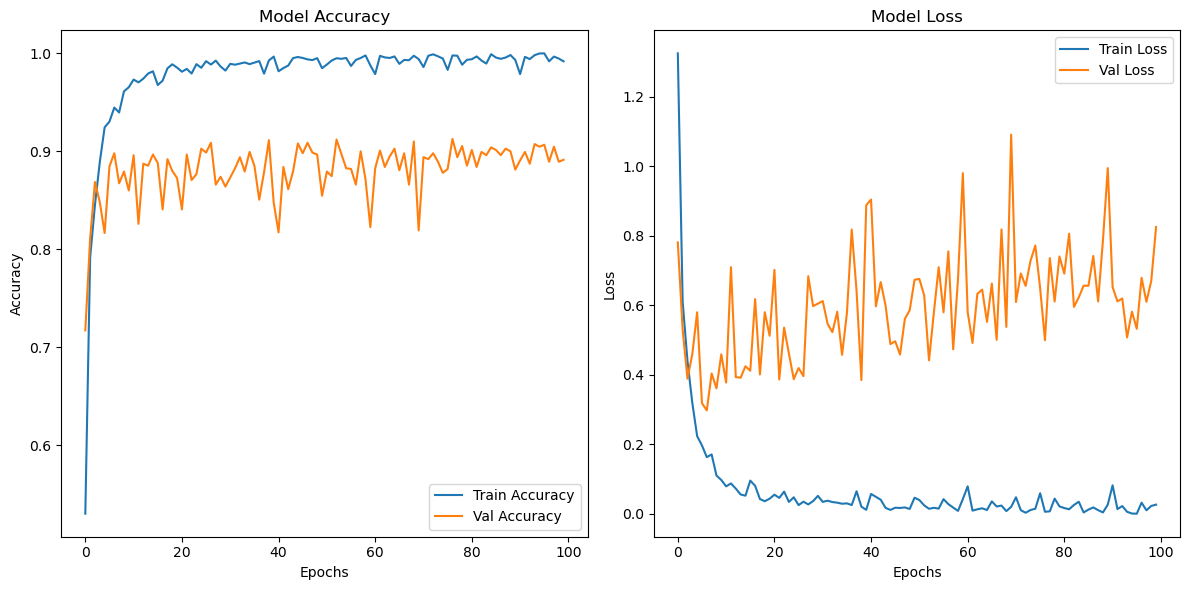

In [8]:
import matplotlib.pyplot as plt

# ฝึกโมเดล
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100
)

# Plot กราฟการฝึก (Training) และการทดสอบ (Validation)
# Plot Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.8929 - loss: 0.9856
Test Accuracy: 0.91


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# เอา label ที่แท้จริง
y_true = test_generator.classes

# พยากรณ์
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# ดึงชื่อคลาส
class_names = list(test_generator.class_indices.keys())


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step


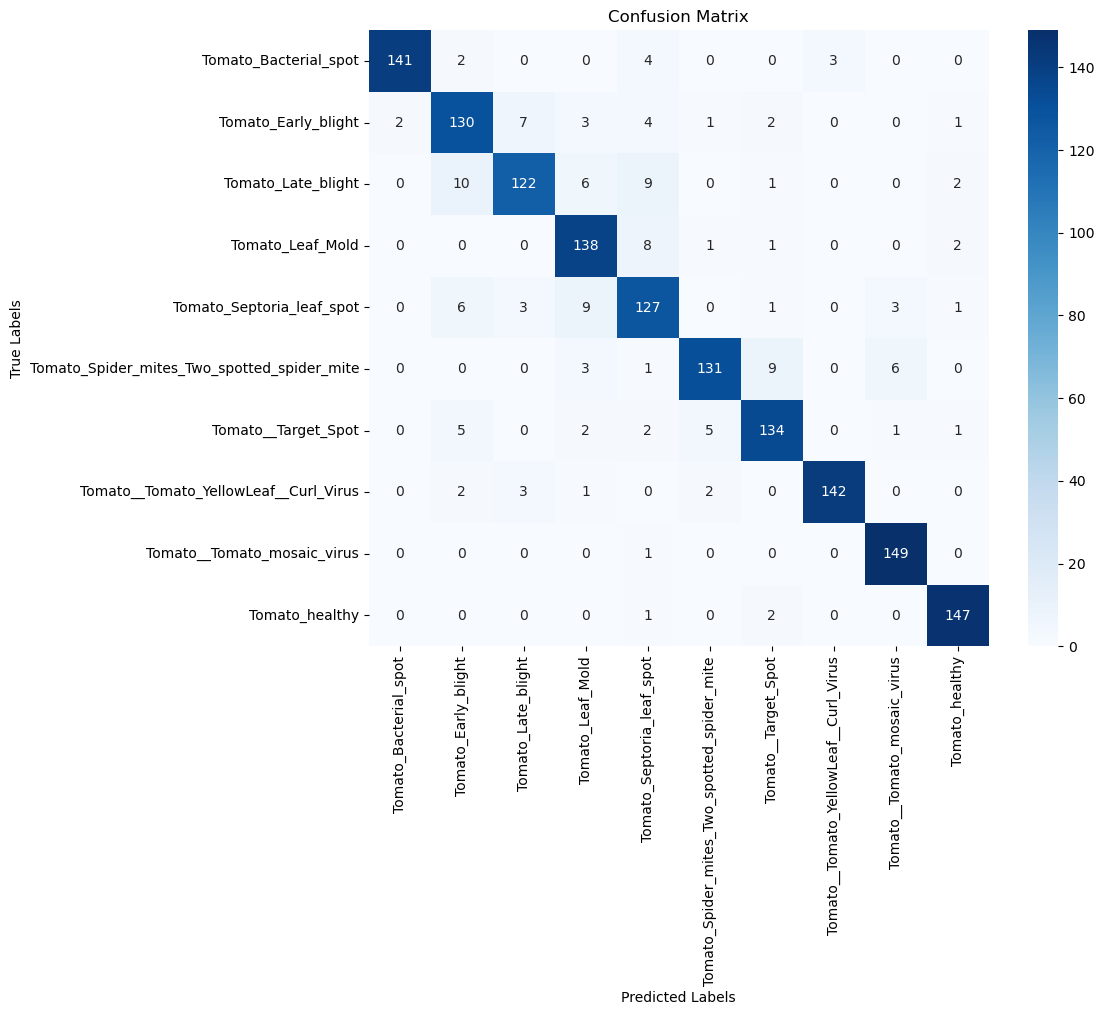

In [12]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [13]:
print(classification_report(y_true, y_pred, target_names=class_names))


                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.99      0.94      0.96       150
                        Tomato_Early_blight       0.84      0.87      0.85       150
                         Tomato_Late_blight       0.90      0.81      0.86       150
                           Tomato_Leaf_Mold       0.85      0.92      0.88       150
                  Tomato_Septoria_leaf_spot       0.81      0.85      0.83       150
Tomato_Spider_mites_Two_spotted_spider_mite       0.94      0.87      0.90       150
                        Tomato__Target_Spot       0.89      0.89      0.89       150
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.98      0.95      0.96       150
                Tomato__Tomato_mosaic_virus       0.94      0.99      0.96       150
                             Tomato_healthy       0.95      0.98      0.97       150

                                   accuracy                    